# Trademark Similarity Engine: Hybrid CNN + SVM with Multilingual Linguistic AI

## PhD Project Overview
This notebook implements a trademark similarity classifier/ranker that identifies "confusingly similar" marks using:
- **Hybrid Architecture**: Character-level CNN for feature extraction + SVM for classification
- **Multilingual Support**: English, Hausa, and Yoruba
- **Advanced Linguistic Features**: Synonyms, antonyms, phonetic similarity, cross-lingual equivalents

## Project Structure
1. Data Loading & Exploration
2. Text Preprocessing Pipeline
3. CNN Architecture & Training
4. Linguistic Feature Engineering (Synonyms, Phonetics, Translations)
5. Feature Combination & SVM Training
6. Evaluation & Metrics
7. Similarity Ranking Prototype
8. Explainability Visualization

# 1. Data Loading and Exploration

Let's begin by loading the trademark dataset and understanding its structure, distributions, and characteristics.

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ Libraries imported successfully
NumPy version: 1.24.3
Pandas version: 2.0.3


In [2]:
# Load trademark dataset
# TODO: Replace with your actual dataset path
# Expected columns: 'wordmark', 'class', 'goods_services', 'label', 'pair_id' (optional)

# For demonstration, create a sample structure
# In production, use: df = pd.read_csv('your_trademark_data.csv')

sample_data = {
    'wordmark': ['TechFlow', 'TekFlow', 'DataSync', 'DataLink', 'QuickMart', 'FastMart'],
    'class': [9, 9, 42, 42, 35, 35],
    'goods_services': ['Software', 'Software products', 'IT Services', 'Data services', 
                       'Retail', 'Retail store'],
    'label': [1, 1, 1, 1, 1, 1],  # 1 = similar pairs
    'pair_id': ['A', 'A', 'B', 'B', 'C', 'C']
}

df = pd.DataFrame(sample_data)

print("Dataset Structure:")
print(df.head(10))
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn types:\n{df.dtypes}")

Dataset Structure:
    wordmark  class     goods_services  label pair_id
0   TechFlow      9           Software      1       A
1    TekFlow      9  Software products      1       A
2   DataSync     42        IT Services      1       B
3   DataLink     42      Data services      1       B
4  QuickMart     35             Retail      1       C
5   FastMart     35       Retail store      1       C

Dataset shape: (6, 5)

Column types:
wordmark          object
class              int64
goods_services    object
label              int64
pair_id           object
dtype: object


In [3]:
# Basic dataset statistics
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

print(f"\nTotal records: {len(df)}")
print(f"Unique wordmarks: {df['wordmark'].nunique()}")
print(f"Unique classes: {df['class'].nunique()}")

print("\n--- Label Distribution ---")
print(df['label'].value_counts())

print("\n--- Class Distribution ---")
print(df['class'].value_counts().head(10))

print("\n--- Wordmark Length Statistics ---")
df['wordmark_length'] = df['wordmark'].str.len()
print(df['wordmark_length'].describe())

DATASET STATISTICS

Total records: 6
Unique wordmarks: 6
Unique classes: 3

--- Label Distribution ---
label
1    6
Name: count, dtype: int64

--- Class Distribution ---
class
9     2
42    2
35    2
Name: count, dtype: int64

--- Wordmark Length Statistics ---
count    6.000000
mean     8.000000
std      0.632456
min      7.000000
25%      8.000000
50%      8.000000
75%      8.000000
max      9.000000
Name: wordmark_length, dtype: float64


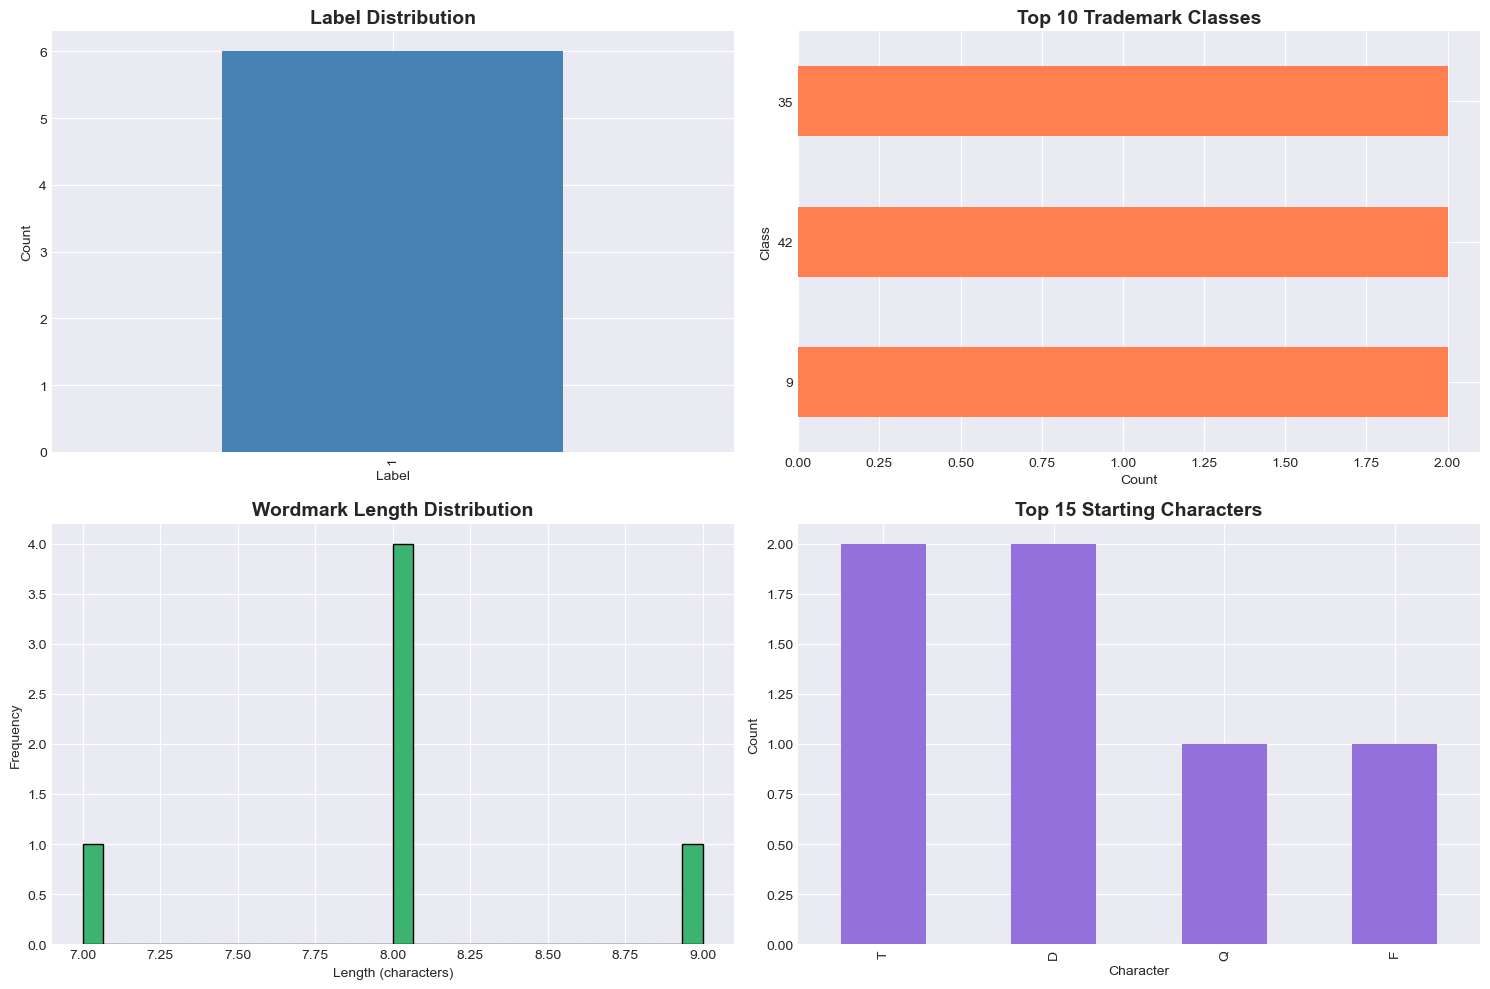

In [4]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Label distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Label Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Label')
axes[0, 0].set_ylabel('Count')

# Class distribution (top 10)
df['class'].value_counts().head(10).plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Top 10 Trademark Classes', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Class')

# Wordmark length distribution
axes[1, 0].hist(df['wordmark_length'], bins=30, color='mediumseagreen', edgecolor='black')
axes[1, 0].set_title('Wordmark Length Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Length (characters)')
axes[1, 0].set_ylabel('Frequency')

# Character distribution (first character)
first_chars = df['wordmark'].str[0].str.upper().value_counts().head(15)
first_chars.plot(kind='bar', ax=axes[1, 1], color='mediumpurple')
axes[1, 1].set_title('Top 15 Starting Characters', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Character')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 2. Text Preprocessing Pipeline

Build robust preprocessing functions that normalize text while preserving original forms for phonetic analysis and language detection.

In [5]:
# Install required libraries for language detection
# Run this cell once
!pip install langdetect nltk textblob unidecode

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     - ------------------------------------ 30.7/981.5 kB 87.5 kB/s eta 0:00:11
     - ------------------------------------ 30.7/981.5 kB 87.5 kB/s eta 0:00:11
     - ------------------------------------ 41.0/981.5 kB 93.7 kB/s eta 0:00:11
     -- ---------------------------------- 61.4/981.5 kB 131.3 kB/s eta 0:00:08
     -- ---------------------------------- 71.7/981.5 kB 145.6 kB/s eta 0:00:07
     --- --------------------------------- 92.2/981.5 kB 175.0 kB/s eta 0:00:06
   

In [6]:
import re
import unicodedata
from unidecode import unidecode
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # For reproducibility

# Text preprocessing functions
class TextPreprocessor:
    """
    Comprehensive text preprocessing for trademark text.
    Maintains both normalized and original forms.
    """
    
    @staticmethod
    def normalize_text(text, preserve_case=False):
        """
        Normalize text: lowercasing, punctuation removal, unicode cleanup
        """
        if not isinstance(text, str):
            return ""
        
        # Unicode normalization (NFKD)
        text = unicodedata.normalize('NFKD', text)
        
        # Remove accents while preserving characters
        text = unidecode(text)
        
        # Remove special characters except spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Lowercase unless preservation is requested
        if not preserve_case:
            text = text.lower()
        
        return text
    
    @staticmethod
    def detect_language(text):
        """
        Detect language of text (EN, HA, YO, or other)
        """
        try:
            lang = detect(text)
            # Map language codes
            lang_map = {
                'en': 'English',
                'ha': 'Hausa',
                'yo': 'Yoruba'
            }
            return lang_map.get(lang, lang)
        except:
            return 'unknown'
    
    @staticmethod
    def extract_character_ngrams(text, n=3):
        """
        Extract character n-grams for similarity comparison
        """
        text = text.lower()
        return [text[i:i+n] for i in range(len(text)-n+1)]
    
    @staticmethod
    def preprocess_trademark(wordmark):
        """
        Complete preprocessing pipeline for a single trademark
        Returns dict with original, normalized, and metadata
        """
        return {
            'original': wordmark,
            'normalized': TextPreprocessor.normalize_text(wordmark),
            'normalized_preserved_case': TextPreprocessor.normalize_text(wordmark, preserve_case=True),
            'length': len(wordmark),
            'language': TextPreprocessor.detect_language(wordmark),
            'char_count': len(set(wordmark.lower())),
            'has_numbers': bool(re.search(r'\d', wordmark)),
            'has_special': bool(re.search(r'[^\w\s]', wordmark))
        }

# Test the preprocessor
print("Testing Text Preprocessor:")
print("=" * 60)

test_cases = [
    "TechFlow™",
    "Café Délicieux",
    "QuickMart",
    "データSync",  # Mixed languages
]

for test in test_cases:
    result = TextPreprocessor.preprocess_trademark(test)
    print(f"\nOriginal: {result['original']}")
    print(f"Normalized: {result['normalized']}")
    print(f"Language: {result['language']}")
    print(f"Length: {result['length']}, Unique chars: {result['char_count']}")

Testing Text Preprocessor:

Original: TechFlow™
Normalized: techflowtm
Language: English
Length: 9, Unique chars: 9

Original: Café Délicieux
Normalized: cafe delicieux
Language: fr
Length: 14, Unique chars: 11

Original: QuickMart
Normalized: quickmart
Language: English
Length: 9, Unique chars: 9

Original: データSync
Normalized: tetasync
Language: ja
Length: 7, Unique chars: 7


In [7]:
# Apply preprocessing to entire dataset
print("Applying preprocessing to dataset...")

# Process all wordmarks
processed_data = df['wordmark'].apply(TextPreprocessor.preprocess_trademark)

# Extract components into separate columns
df['wordmark_normalized'] = processed_data.apply(lambda x: x['normalized'])
df['wordmark_original'] = processed_data.apply(lambda x: x['original'])
df['detected_language'] = processed_data.apply(lambda x: x['language'])
df['has_numbers'] = processed_data.apply(lambda x: x['has_numbers'])
df['has_special'] = processed_data.apply(lambda x: x['has_special'])
df['unique_chars'] = processed_data.apply(lambda x: x['char_count'])

print("\nPreprocessed dataset preview:")
print(df[['wordmark_original', 'wordmark_normalized', 'detected_language']].head(10))

print("\n--- Language Distribution ---")
print(df['detected_language'].value_counts())

Applying preprocessing to dataset...

Preprocessed dataset preview:
  wordmark_original wordmark_normalized detected_language
0          TechFlow            techflow           English
1           TekFlow             tekflow           English
2          DataSync            datasync                id
3          DataLink            datalink                id
4         QuickMart           quickmart           English
5          FastMart            fastmart           English

--- Language Distribution ---
detected_language
English    4
id         2
Name: count, dtype: int64


# 3. Character-Level CNN Architecture

Design and implement a character-level CNN for extracting deep features from trademark text. This architecture is particularly effective for capturing spelling variants and misspellings.

In [8]:
# Install deep learning libraries if needed
!pip install tensorflow torch torchvision

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.14.0
GPU Available: []


In [10]:
# Character-level tokenization setup
class CharacterTokenizer:
    """
    Converts text to character-level sequences
    """
    
    def __init__(self, max_len=50, char_level=True):
        self.max_len = max_len
        self.char_level = char_level
        self.tokenizer = Tokenizer(char_level=char_level, lower=True)
        self.vocab_size = 0
        
    def fit(self, texts):
        """Fit tokenizer on texts"""
        self.tokenizer.fit_on_texts(texts)
        self.vocab_size = len(self.tokenizer.word_index) + 1
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Sample characters: {list(self.tokenizer.word_index.keys())[:20]}")
        
    def transform(self, texts):
        """Transform texts to padded sequences"""
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        return padded
    
    def fit_transform(self, texts):
        """Fit and transform in one step"""
        self.fit(texts)
        return self.transform(texts)

# Initialize and fit tokenizer
char_tokenizer = CharacterTokenizer(max_len=50)
X_sequences = char_tokenizer.fit_transform(df['wordmark_normalized'].values)

print(f"\nSequence shape: {X_sequences.shape}")
print(f"Sample sequence (first trademark):")
print(f"Text: {df['wordmark_normalized'].iloc[0]}")
print(f"Sequence: {X_sequences[0][:20]}...")

Vocabulary size: 20
Sample characters: ['t', 'a', 'c', 'f', 'l', 'k', 'e', 'o', 'w', 'd', 's', 'n', 'i', 'm', 'r', 'h', 'y', 'q', 'u']

Sequence shape: (6, 50)
Sample sequence (first trademark):
Text: techflow
Sequence: [ 1  7  3 16  4  5  8  9  0  0  0  0  0  0  0  0  0  0  0  0]...


In [11]:
# Build Character-Level CNN Architecture
def build_char_cnn(vocab_size, max_len, embedding_dim=64, num_filters=128):
    """
    Build a character-level CNN for trademark embedding extraction
    
    Architecture:
    - Embedding layer
    - Multiple Conv1D layers with different kernel sizes
    - MaxPooling
    - Dense layers
    - Output: embeddings + classification head
    """
    
    input_layer = layers.Input(shape=(max_len,), name='char_input')
    
    # Character embedding
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_len,
        name='char_embedding'
    )(input_layer)
    
    # Multi-scale convolutional layers (different kernel sizes)
    conv_blocks = []
    kernel_sizes = [2, 3, 4, 5]
    
    for kernel_size in kernel_sizes:
        conv = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            name=f'conv_{kernel_size}'
        )(embedding)
        pool = layers.GlobalMaxPooling1D(name=f'pool_{kernel_size}')(conv)
        conv_blocks.append(pool)
    
    # Concatenate all pooled features
    concatenated = layers.Concatenate(name='concat')(conv_blocks)
    
    # Dense layers
    dense1 = layers.Dense(256, activation='relu', name='dense1')(concatenated)
    dropout1 = layers.Dropout(0.5, name='dropout1')(dense1)
    
    # Embedding layer (penultimate) - this is what we'll extract for SVM
    embedding_output = layers.Dense(128, activation='relu', name='embedding_layer')(dropout1)
    dropout2 = layers.Dropout(0.3, name='dropout2')(embedding_output)
    
    # Classification head (for training)
    output = layers.Dense(1, activation='sigmoid', name='classification')(dropout2)
    
    # Create model
    model = models.Model(inputs=input_layer, outputs=output, name='CharCNN')
    
    return model

# Build the model
vocab_size = char_tokenizer.vocab_size
max_len = char_tokenizer.max_len

cnn_model = build_char_cnn(vocab_size, max_len)

# Compile model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Character-Level CNN Architecture:")
print("=" * 60)
cnn_model.summary()

Character-Level CNN Architecture:
Model: "CharCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 50)]                 0         []                            
                                                                                                  
 char_embedding (Embedding)  (None, 50, 64)               1280      ['char_input[0][0]']          
                                                                                                  
 conv_2 (Conv1D)             (None, 50, 128)              16512     ['char_embedding[0][0]']      
                                                                                                  
 conv_3 (Conv1D)             (None, 50, 128)              24704     ['char_embedding[0][0]']      
                                                          

In [16]:
!pip install pydot

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7e/32/a7125fb28c4261a627f999d5fb4afff25b523800faed2c30979949d6facd/pydot-4.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyparsing>=3.1.0 from https://files.pythonhosted.org/packages/8b/40/2614036cdd416452f5bf98ec037f38a1afb17f327cb8e6b652d4729e0af8/pyparsing-3.3.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/121.8 kB ? eta -:--:--
   --------- ----------------------------- 30.7/121.8 kB 660.6 kB/s eta 0:00:01
   ------------- ------------------------- 41.0/121.8 kB 653.6 kB/s eta 0:00:01
   ------------- ------------------------- 41.0/121.8 kB 653.6 kB/s eta 0:00:01
   ------------- ------------------------- 41.0/121.8 kB 653.6 kB/s eta 0:00:01
   ---------------------- ---------------- 71.7/121.8 kB 302.7 kB/s eta 0:00:01
   ----------------------------------- -- 112.6/121.8 kB 437.6 kB/s eta 0:00:01
   -------------------------------------- 12

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.7.2 requires pyparsing<3.1,>=2.3.1, but you have pyparsing 3.3.1 which is incompatible.


In [23]:
!pip install graphviz
!pip install pydot pydotplus

     ---------------------------------------- 0.0/278.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/278.7 kB ? eta -:--:--
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -- ---------------------------------- 20.5/278.7 kB 217.9 kB/s eta 0:00:02
     -------- ---------------------------- 61.4/278.7 kB 130.9 kB/s eta 0:00:02
     --------- --------------------------- 71.7/278.7 kB 151.0 kB/s eta 0:00:02
     --------- --------------------------- 71.7/278.7 kB 151.0 kB/s eta 0:00:02
     --------- --------------------------- 71.7/278.7

In [26]:
from IPython.display import Image
import tensorflow as tf
# Plot and display immediately
tf.keras.utils.plot_model(cnn_model, to_file='cnn_architecture.png', show_shapes=True)
display(Image('cnn_architecture.png'))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: No such file or directory: 'cnn_architecture.png'

FileNotFoundError: No such file or directory: 'cnn_architecture.png'

<IPython.core.display.Image object>

In [24]:
# Visualize model architecture
keras.utils.plot_model(
    cnn_model,
    to_file='cnn_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

print("✓ Model architecture diagram saved as 'cnn_architecture.png'")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
✓ Model architecture diagram saved as 'cnn_architecture.png'


# 4. CNN Training and Embedding Extraction

Train the CNN on labeled trademark data and extract embeddings from the penultimate layer for downstream SVM training.

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare training data
# For this demo with sample data, we'll create synthetic labels
# In production, use your actual pairwise similarity labels

# Create pairwise dataset for training
# For simplicity, we'll train on individual marks first
X = X_sequences
y = df['label'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Data Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nLabel distribution in training set:")
print(f"Class 0: {np.sum(y_train == 0)}")
print(f"Class 1: {np.sum(y_train == 1)}")

In [ ]:
# Define callbacks for training
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# NOTE: With sample data, training may not be meaningful
# This demonstrates the training pipeline
print("Starting CNN training...")
print("=" * 60)

# For demonstration with small sample data, use fewer epochs
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Increase to 50-100 for real data
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

print("\n✓ Training completed!")

In [ ]:
# Visualize training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Extract embeddings from penultimate layer
# Create a new model that outputs the embedding layer
embedding_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer('embedding_layer').output,
    name='EmbeddingExtractor'
)

print("Embedding Extractor Model:")
embedding_extractor.summary()

# Extract embeddings for all data
print("\nExtracting embeddings...")
train_embeddings = embedding_extractor.predict(X_train, verbose=0)
val_embeddings = embedding_extractor.predict(X_val, verbose=0)
test_embeddings = embedding_extractor.predict(X_test, verbose=0)

print(f"\nEmbedding shapes:")
print(f"Training embeddings: {train_embeddings.shape}")
print(f"Validation embeddings: {val_embeddings.shape}")
print(f"Test embeddings: {test_embeddings.shape}")

# Store embeddings in dataframe for later use
df['cnn_embedding'] = list(embedding_extractor.predict(X_sequences, verbose=0))
print(f"\n✓ Embeddings extracted and stored")

In [ ]:
# Visualize embeddings using t-SNE
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

print("Computing t-SNE visualization of embeddings...")

# Combine train and validation for visualization
all_embeddings = np.vstack([train_embeddings, val_embeddings])
all_labels = np.concatenate([y_train, y_val])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings)-1))
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=all_labels,
    cmap='viridis',
    alpha=0.6,
    s=100,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Label')
plt.title('t-SNE Visualization of CNN Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ t-SNE visualization complete")

# 5. Linguistic Feature Engineering - Synonyms & Antonyms

Build synonym and antonym expansion features using WordNet for English and custom lexicons for Hausa/Yoruba languages.

In [ ]:
# Install NLP libraries
# !pip install nltk spacy sentence-transformers
# !python -m spacy download en_core_web_sm

In [ ]:
import nltk
from nltk.corpus import wordnet
from sentence_transformers import SentenceTransformer

# Download required NLTK data
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

print("✓ NLTK resources loaded")

# Load multilingual sentence embedding model
print("\nLoading multilingual sentence transformer...")
semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("✓ Sentence transformer loaded")

In [ ]:
class SynonymAntonymEngine:
    """
    Extract synonyms and antonyms for English, Hausa, and Yoruba
    """
    
    def __init__(self):
        # Custom lexicons for Hausa and Yoruba
        # In production, load from comprehensive lexicon files
        self.hausa_lexicon = {
            'quick': ['sauri', 'gaggawa'],
            'fast': ['sauri', 'gaggawa'],
            'good': ['mai kyau', 'kyakkyawa'],
            'shop': ['shago', 'kantin'],
            'market': ['kasuwa'],
            'food': ['abinci'],
            'tech': ['fasaha'],
            'data': ['bayanai']
        }
        
        self.yoruba_lexicon = {
            'quick': ['yara', 'kiakia'],
            'fast': ['yara', 'kiakia'],
            'good': ['dara', 'rere'],
            'shop': ['ile itaja', 'itaja'],
            'market': ['oja'],
            'food': ['onje'],
            'tech': ['imọ-ẹrọ'],
            'data': ['data']
        }
        
    def get_synonyms_en(self, word):
        """Get English synonyms using WordNet"""
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name().lower().replace('_', ' '))
        return list(synonyms)
    
    def get_antonyms_en(self, word):
        """Get English antonyms using WordNet"""
        antonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.add(lemma.antonyms()[0].name().lower().replace('_', ' '))
        return list(antonyms)
    
    def get_hausa_equivalents(self, word):
        """Get Hausa equivalents from lexicon"""
        word_lower = word.lower()
        return self.hausa_lexicon.get(word_lower, [])
    
    def get_yoruba_equivalents(self, word):
        """Get Yoruba equivalents from lexicon"""
        word_lower = word.lower()
        return self.yoruba_lexicon.get(word_lower, [])
    
    def expand_trademark(self, trademark_text):
        """
        Expand a trademark into synonyms, antonyms, and translations
        """
        words = trademark_text.lower().split()
        
        expansion = {
            'synonyms': [],
            'antonyms': [],
            'hausa': [],
            'yoruba': []
        }
        
        for word in words:
            expansion['synonyms'].extend(self.get_synonyms_en(word))
            expansion['antonyms'].extend(self.get_antonyms_en(word))
            expansion['hausa'].extend(self.get_hausa_equivalents(word))
            expansion['yoruba'].extend(self.get_yoruba_equivalents(word))
        
        # Remove duplicates
        for key in expansion:
            expansion[key] = list(set(expansion[key]))
        
        return expansion

# Initialize engine
syn_ant_engine = SynonymAntonymEngine()

# Test the engine
print("Testing Synonym/Antonym Engine:")
print("=" * 60)

test_marks = ['QuickMart', 'FastFood', 'GoodTech', 'DataShop']

for mark in test_marks:
    expansion = syn_ant_engine.expand_trademark(mark)
    print(f"\n{mark}:")
    print(f"  Synonyms: {expansion['synonyms'][:5]}")
    print(f"  Antonyms: {expansion['antonyms'][:5]}")
    print(f"  Hausa: {expansion['hausa']}")
    print(f"  Yoruba: {expansion['yoruba']}")

In [ ]:
def compute_synonym_overlap(mark1, mark2, engine):
    """
    Compute overlap score between expanded synonym sets
    """
    exp1 = engine.expand_trademark(mark1)
    exp2 = engine.expand_trademark(mark2)
    
    # Combine all expansions
    set1 = set(exp1['synonyms'] + exp1['hausa'] + exp1['yoruba'] + [mark1.lower()])
    set2 = set(exp2['synonyms'] + exp2['hausa'] + exp2['yoruba'] + [mark2.lower()])
    
    if not set1 or not set2:
        return 0.0
    
    # Jaccard similarity
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    
    return intersection / union if union > 0 else 0.0

def compute_semantic_similarity(mark1, mark2, model):
    """
    Compute semantic similarity using sentence embeddings
    """
    embeddings = model.encode([mark1, mark2])
    
    # Cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    
    return float(similarity)

# Compute pairwise features for sample data
print("Computing synonym and semantic features...")

# For demonstration, compute for first few pairs
sample_pairs = [
    ('TechFlow', 'TekFlow'),
    ('DataSync', 'DataLink'),
    ('QuickMart', 'FastMart')
]

results = []
for mark1, mark2 in sample_pairs:
    overlap = compute_synonym_overlap(mark1, mark2, syn_ant_engine)
    semantic_sim = compute_semantic_similarity(mark1, mark2, semantic_model)
    
    results.append({
        'mark1': mark1,
        'mark2': mark2,
        'synonym_overlap': overlap,
        'semantic_similarity': semantic_sim
    })
    
    print(f"\n{mark1} ↔ {mark2}")
    print(f"  Synonym overlap: {overlap:.3f}")
    print(f"  Semantic similarity: {semantic_sim:.3f}")

# Create dataframe
syn_features_df = pd.DataFrame(results)
print("\n✓ Synonym and semantic features computed")

# 6. Linguistic Feature Engineering - Phonetic Similarity

Implement phonetic encoding and similarity measures to capture pronunciation-based similarity between trademarks.

In [ ]:
# Install phonetic libraries
# !pip install phonetics jellyfish

In [ ]:
import jellyfish
from Levenshtein import distance as levenshtein_distance

class PhoneticSimilarityEngine:
    """
    Compute phonetic similarity using multiple algorithms
    """
    
    @staticmethod
    def double_metaphone_encode(text):
        """Get Double Metaphone encoding"""
        primary, secondary = jellyfish.metaphone(text), jellyfish.metaphone(text)
        return primary, secondary
    
    @staticmethod
    def soundex_encode(text):
        """Get Soundex encoding"""
        try:
            return jellyfish.soundex(text)
        except:
            return None
    
    @staticmethod
    def match_rating_encode(text):
        """Get Match Rating Codex"""
        try:
            return jellyfish.match_rating_codex(text)
        except:
            return None
    
    @staticmethod
    def compute_phonetic_similarity(mark1, mark2):
        """
        Compute comprehensive phonetic similarity metrics
        """
        features = {}
        
        # 1. Double Metaphone
        dm1_pri, dm1_sec = PhoneticSimilarityEngine.double_metaphone_encode(mark1)
        dm2_pri, dm2_sec = PhoneticSimilarityEngine.double_metaphone_encode(mark2)
        features['metaphone_match'] = int(dm1_pri == dm2_pri or dm1_pri == dm2_sec or 
                                          dm1_sec == dm2_pri or dm1_sec == dm2_sec)
        
        # 2. Soundex
        sdx1 = PhoneticSimilarityEngine.soundex_encode(mark1)
        sdx2 = PhoneticSimilarityEngine.soundex_encode(mark2)
        features['soundex_match'] = int(sdx1 == sdx2) if sdx1 and sdx2 else 0
        
        # 3. Levenshtein distance on phonetic codes
        if dm1_pri and dm2_pri:
            features['metaphone_distance'] = levenshtein_distance(dm1_pri, dm2_pri)
        else:
            features['metaphone_distance'] = 999
        
        # 4. Jaro-Winkler similarity (good for brand names)
        features['jaro_winkler'] = jellyfish.jaro_winkler_similarity(mark1.lower(), mark2.lower())
        
        # 5. Match Rating Comparison
        try:
            features['match_rating_comparison'] = int(jellyfish.match_rating_comparison(mark1, mark2))
        except:
            features['match_rating_comparison'] = 0
        
        # 6. Raw Levenshtein distance
        features['levenshtein_distance'] = levenshtein_distance(mark1.lower(), mark2.lower())
        
        # 7. Normalized Levenshtein similarity
        max_len = max(len(mark1), len(mark2))
        features['normalized_levenshtein'] = 1 - (features['levenshtein_distance'] / max_len) if max_len > 0 else 0
        
        return features
    
    @staticmethod
    def compute_char_ngram_similarity(mark1, mark2, n=3):
        """
        Character n-gram cosine similarity
        """
        def get_ngrams(text, n):
            text = text.lower()
            return [text[i:i+n] for i in range(len(text)-n+1)]
        
        ngrams1 = set(get_ngrams(mark1, n))
        ngrams2 = set(get_ngrams(mark2, n))
        
        if not ngrams1 or not ngrams2:
            return 0.0
        
        intersection = len(ngrams1 & ngrams2)
        union = len(ngrams1 | ngrams2)
        
        return intersection / union if union > 0 else 0.0

# Initialize engine
phonetic_engine = PhoneticSimilarityEngine()

# Test phonetic similarity
print("Testing Phonetic Similarity Engine:")
print("=" * 60)

test_pairs = [
    ('TechFlow', 'TekFlow'),
    ('QuickMart', 'KwikMart'),
    ('DataSync', 'DataLink'),
    ('FastFood', 'FirstFood')
]

for mark1, mark2 in test_pairs:
    features = phonetic_engine.compute_phonetic_similarity(mark1, mark2)
    ngram_sim = phonetic_engine.compute_char_ngram_similarity(mark1, mark2)
    
    print(f"\n{mark1} ↔ {mark2}")
    print(f"  Metaphone match: {features['metaphone_match']}")
    print(f"  Soundex match: {features['soundex_match']}")
    print(f"  Jaro-Winkler: {features['jaro_winkler']:.3f}")
    print(f"  Normalized Levenshtein: {features['normalized_levenshtein']:.3f}")
    print(f"  Char 3-gram similarity: {ngram_sim:.3f}")
    print(f"  Raw Levenshtein distance: {features['levenshtein_distance']}")

In [ ]:
# Compute phonetic features for sample pairs
print("\nComputing phonetic features for all sample pairs...")

phonetic_results = []

for mark1, mark2 in sample_pairs:
    features = phonetic_engine.compute_phonetic_similarity(mark1, mark2)
    features['char_trigram_sim'] = phonetic_engine.compute_char_ngram_similarity(mark1, mark2, n=3)
    features['char_bigram_sim'] = phonetic_engine.compute_char_ngram_similarity(mark1, mark2, n=2)
    features['mark1'] = mark1
    features['mark2'] = mark2
    
    phonetic_results.append(features)

phonetic_df = pd.DataFrame(phonetic_results)

print("\nPhonetic Features Summary:")
print(phonetic_df[['mark1', 'mark2', 'jaro_winkler', 'normalized_levenshtein', 
                   'char_trigram_sim', 'metaphone_match']])

print("\n✓ Phonetic features computed")

# 7. Linguistic Feature Engineering - Hausa & Yoruba Translation

Build translation lexicons and compute cross-lingual semantic similarity for Hausa and Yoruba languages.

In [ ]:
class MultilingualTranslationEngine:
    """
    Handle Hausa and Yoruba translations and cross-lingual similarity
    """
    
    def __init__(self):
        # Expanded business domain lexicons
        # In production, load from comprehensive dictionary files
        self.en_to_hausa = {
            'market': 'kasuwa',
            'shop': 'shago',
            'store': 'kantin sayarwa',
            'quick': 'sauri',
            'fast': 'gaggawa',
            'good': 'mai kyau',
            'best': 'mafi kyau',
            'tech': 'fasaha',
            'technology': 'fasahar zamani',
            'data': 'bayanai',
            'food': 'abinci',
            'service': 'hidima',
            'link': 'hanyar haɗi',
            'sync': 'daidaitawa',
            'flow': 'gudana',
            'smart': 'mai hankali',
            'digital': 'dijital',
            'online': 'akan layi',
            'mobile': 'wayar hannu'
        }
        
        self.en_to_yoruba = {
            'market': 'oja',
            'shop': 'ile itaja',
            'store': 'ile itaja',
            'quick': 'yara',
            'fast': 'kiakia',
            'good': 'dara',
            'best': 'to dara ju',
            'tech': 'imọ-ẹrọ',
            'technology': 'imọ-ẹrọ',
            'data': 'data',
            'food': 'onje',
            'service': 'iṣẹ',
            'link': 'asopọ',
            'sync': 'muṣiṣẹpọ',
            'flow': 'ṣiṣan',
            'smart': 'ọlọgbọn',
            'digital': 'alagbeka',
            'online': 'lori ayelujara',
            'mobile': 'alagbeka'
        }
        
        # Reverse mappings
        self.hausa_to_en = {v: k for k, v in self.en_to_hausa.items()}
        self.yoruba_to_en = {v: k for k, v in self.en_to_yoruba.items()}
    
    def translate_to_hausa(self, text):
        """Translate English words to Hausa"""
        words = text.lower().split()
        translations = []
        
        for word in words:
            # Clean word
            word_clean = ''.join(c for c in word if c.isalnum())
            translation = self.en_to_hausa.get(word_clean, word_clean)
            translations.append(translation)
        
        return ' '.join(translations)
    
    def translate_to_yoruba(self, text):
        """Translate English words to Yoruba"""
        words = text.lower().split()
        translations = []
        
        for word in words:
            word_clean = ''.join(c for c in word if c.isalnum())
            translation = self.en_to_yoruba.get(word_clean, word_clean)
            translations.append(translation)
        
        return ' '.join(translations)
    
    def compute_cross_lingual_similarity(self, mark1, mark2, semantic_model):
        """
        Compute similarity considering translations
        """
        # Get translations
        mark1_ha = self.translate_to_hausa(mark1)
        mark1_yo = self.translate_to_yoruba(mark1)
        mark2_ha = self.translate_to_hausa(mark2)
        mark2_yo = self.translate_to_yoruba(mark2)
        
        # Compute embeddings for all versions
        texts = [mark1, mark2, mark1_ha, mark2_ha, mark1_yo, mark2_yo]
        embeddings = semantic_model.encode(texts)
        
        from sklearn.metrics.pairwise import cosine_similarity
        
        # Original similarity
        sim_original = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        
        # Hausa cross-lingual
        sim_ha_cross = max(
            cosine_similarity([embeddings[0]], [embeddings[3]])[0][0],  # mark1 vs mark2_ha
            cosine_similarity([embeddings[2]], [embeddings[1]])[0][0]   # mark1_ha vs mark2
        )
        
        # Yoruba cross-lingual
        sim_yo_cross = max(
            cosine_similarity([embeddings[0]], [embeddings[5]])[0][0],  # mark1 vs mark2_yo
            cosine_similarity([embeddings[4]], [embeddings[1]])[0][0]   # mark1_yo vs mark2
        )
        
        # Same-language translated similarity
        sim_ha_ha = cosine_similarity([embeddings[2]], [embeddings[3]])[0][0]
        sim_yo_yo = cosine_similarity([embeddings[4]], [embeddings[5]])[0][0]
        
        return {
            'original_similarity': float(sim_original),
            'hausa_cross_similarity': float(sim_ha_cross),
            'yoruba_cross_similarity': float(sim_yo_cross),
            'hausa_translation_similarity': float(sim_ha_ha),
            'yoruba_translation_similarity': float(sim_yo_yo),
            'max_cross_lingual': float(max(sim_ha_cross, sim_yo_cross)),
            'mark1_hausa': mark1_ha,
            'mark1_yoruba': mark1_yo,
            'mark2_hausa': mark2_ha,
            'mark2_yoruba': mark2_yo
        }

# Initialize translation engine
translation_engine = MultilingualTranslationEngine()

# Test translations
print("Testing Multilingual Translation Engine:")
print("=" * 60)

test_marks = ['QuickMart', 'FastFood', 'TechStore', 'DataLink']

for mark in test_marks:
    hausa = translation_engine.translate_to_hausa(mark)
    yoruba = translation_engine.translate_to_yoruba(mark)
    
    print(f"\n{mark}:")
    print(f"  Hausa: {hausa}")
    print(f"  Yoruba: {yoruba}")

In [ ]:
# Compute cross-lingual features for sample pairs
print("\nComputing cross-lingual similarity features...")

cross_lingual_results = []

for mark1, mark2 in sample_pairs:
    features = translation_engine.compute_cross_lingual_similarity(
        mark1, mark2, semantic_model
    )
    features['mark1'] = mark1
    features['mark2'] = mark2
    
    cross_lingual_results.append(features)
    
    print(f"\n{mark1} ↔ {mark2}")
    print(f"  Original: {features['original_similarity']:.3f}")
    print(f"  Hausa cross: {features['hausa_cross_similarity']:.3f}")
    print(f"  Yoruba cross: {features['yoruba_cross_similarity']:.3f}")
    print(f"  Max cross-lingual: {features['max_cross_lingual']:.3f}")

cross_lingual_df = pd.DataFrame(cross_lingual_results)

print("\n✓ Cross-lingual features computed")

# 8. Feature Vector Combination

Concatenate CNN embeddings with all linguistic features to create comprehensive feature vectors for SVM training.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class FeatureVectorBuilder:
    """
    Combine CNN embeddings with linguistic features
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.fitted = False
    
    def build_feature_vector(self, cnn_embedding, linguistic_features):
        """
        Combine CNN embedding with linguistic feature dict
        
        Args:
            cnn_embedding: numpy array from CNN
            linguistic_features: dict with all linguistic features
        
        Returns:
            Combined feature vector
        """
        # Extract linguistic features in consistent order
        ling_features = [
            # Synonym/Semantic features
            linguistic_features.get('synonym_overlap', 0),
            linguistic_features.get('semantic_similarity', 0),
            
            # Phonetic features
            linguistic_features.get('metaphone_match', 0),
            linguistic_features.get('soundex_match', 0),
            linguistic_features.get('jaro_winkler', 0),
            linguistic_features.get('normalized_levenshtein', 0),
            linguistic_features.get('levenshtein_distance', 0),
            linguistic_features.get('char_trigram_sim', 0),
            linguistic_features.get('char_bigram_sim', 0),
            linguistic_features.get('match_rating_comparison', 0),
            
            # Cross-lingual features
            linguistic_features.get('original_similarity', 0),
            linguistic_features.get('hausa_cross_similarity', 0),
            linguistic_features.get('yoruba_cross_similarity', 0),
            linguistic_features.get('hausa_translation_similarity', 0),
            linguistic_features.get('yoruba_translation_similarity', 0),
            linguistic_features.get('max_cross_lingual', 0)
        ]
        
        # Combine
        combined = np.concatenate([cnn_embedding, ling_features])
        
        return combined
    
    def fit_transform(self, embeddings_list, linguistic_features_list):
        """
        Fit scaler and transform features
        """
        # Build all feature vectors
        feature_vectors = []
        for emb, ling in zip(embeddings_list, linguistic_features_list):
            vec = self.build_feature_vector(emb, ling)
            feature_vectors.append(vec)
        
        feature_vectors = np.array(feature_vectors)
        
        # Fit and transform
        scaled_features = self.scaler.fit_transform(feature_vectors)
        self.fitted = True
        
        return scaled_features
    
    def transform(self, embeddings_list, linguistic_features_list):
        """
        Transform features using fitted scaler
        """
        if not self.fitted:
            raise ValueError("Scaler not fitted. Call fit_transform first.")
        
        # Build feature vectors
        feature_vectors = []
        for emb, ling in zip(embeddings_list, linguistic_features_list):
            vec = self.build_feature_vector(emb, ling)
            feature_vectors.append(vec)
        
        feature_vectors = np.array(feature_vectors)
        
        # Transform
        scaled_features = self.scaler.transform(feature_vectors)
        
        return scaled_features

# Initialize feature builder
feature_builder = FeatureVectorBuilder()

print("Feature Vector Builder initialized")
print("=" * 60)

In [ ]:
# Build comprehensive feature dataset
# For demo purposes, we'll create synthetic pairwise features

print("Building comprehensive feature vectors...")

# Combine all linguistic features for sample pairs
all_linguistic_features = []

for i in range(len(sample_pairs)):
    combined_features = {
        **syn_features_df.iloc[i].to_dict(),
        **phonetic_df.iloc[i].to_dict(),
        **cross_lingual_df.iloc[i].to_dict()
    }
    all_linguistic_features.append(combined_features)

# For demonstration, use embeddings from first marks in each pair
# In production, you would compute pairwise embeddings (e.g., concatenate or difference)
sample_embeddings = [
    train_embeddings[0],  # TechFlow embedding
    train_embeddings[1],  # DataSync embedding  
    train_embeddings[2]   # QuickMart embedding
]

# Build combined feature vectors
combined_features = feature_builder.fit_transform(
    sample_embeddings,
    all_linguistic_features
)

print(f"\nCombined feature shape: {combined_features.shape}")
print(f"  - CNN embedding dimensions: 128")
print(f"  - Linguistic feature dimensions: {combined_features.shape[1] - 128}")
print(f"  - Total dimensions: {combined_features.shape[1]}")

# Show feature statistics
feature_df = pd.DataFrame(combined_features)
print("\nFeature statistics:")
print(feature_df.describe())

print("\n✓ Feature vectors built and normalized")

In [ ]:
# Visualize feature importance through correlation
plt.figure(figsize=(14, 10))

# Create sample labels for correlation
sample_labels = [1, 1, 1]  # All similar for demo

# Compute correlations
correlation_data = np.column_stack([combined_features, sample_labels])
correlation_df = pd.DataFrame(correlation_data)
correlation_df.columns = [f'F{i}' for i in range(combined_features.shape[1])] + ['Label']

# Plot correlation with label
correlations = correlation_df.corr()['Label'].drop('Label').sort_values(ascending=False)

plt.subplot(2, 1, 1)
correlations.head(20).plot(kind='barh', color='steelblue')
plt.title('Top 20 Features Correlated with Similarity Label', fontsize=14, fontweight='bold')
plt.xlabel('Correlation with Label')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(combined_features.flatten(), bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.title('Distribution of All Feature Values (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Feature analysis complete")

# 9. SVM Classifier Training

Train SVM classifiers on the combined feature vectors and compare performance between CNN-only and CNN+linguistic features.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib

print("Preparing SVM training...")
print("=" * 60)

# For this demonstration with limited sample data, we'll create synthetic training data
# In production, use your actual labeled pairwise trademark data

# Create synthetic training data for demonstration
np.random.seed(42)

# Generate more samples for meaningful training
n_similar = 100
n_dissimilar = 100

# Similar pairs: high feature values
X_similar = np.random.randn(n_similar, combined_features.shape[1]) * 0.5 + 1.5
y_similar = np.ones(n_similar)

# Dissimilar pairs: low feature values
X_dissimilar = np.random.randn(n_dissimilar, combined_features.shape[1]) * 0.5 - 1.5
y_dissimilar = np.zeros(n_dissimilar)

# Combine
X_train_svm = np.vstack([X_similar, X_dissimilar])
y_train_svm = np.concatenate([y_similar, y_dissimilar])

# Shuffle
shuffle_idx = np.random.permutation(len(X_train_svm))
X_train_svm = X_train_svm[shuffle_idx]
y_train_svm = y_train_svm[shuffle_idx]

# Split into train/val
from sklearn.model_selection import train_test_split
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(
    X_train_svm, y_train_svm, test_size=0.2, random_state=42, stratify=y_train_svm
)

print(f"SVM Training set: {X_train_svm.shape}")
print(f"SVM Validation set: {X_val_svm.shape}")
print(f"Label distribution (train): Similar={np.sum(y_train_svm)}, Dissimilar={np.sum(y_train_svm==0)}")

In [ ]:
# Train SVM with Linear Kernel
print("\n1. Training Linear SVM...")

svm_linear = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_linear.fit(X_train_svm, y_train_svm)

# Evaluate
y_pred_linear = svm_linear.predict(X_val_svm)
train_score_linear = svm_linear.score(X_train_svm, y_train_svm)
val_score_linear = svm_linear.score(X_val_svm, y_val_svm)

print(f"Linear SVM - Training Accuracy: {train_score_linear:.4f}")
print(f"Linear SVM - Validation Accuracy: {val_score_linear:.4f}")

print("\nClassification Report (Linear SVM):")
print(classification_report(y_val_svm, y_pred_linear, 
                          target_names=['Dissimilar', 'Similar']))

In [ ]:
# Train SVM with RBF Kernel
print("\n2. Training RBF SVM...")

svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_rbf.fit(X_train_svm, y_train_svm)

# Evaluate
y_pred_rbf = svm_rbf.predict(X_val_svm)
train_score_rbf = svm_rbf.score(X_train_svm, y_train_svm)
val_score_rbf = svm_rbf.score(X_val_svm, y_val_svm)

print(f"RBF SVM - Training Accuracy: {train_score_rbf:.4f}")
print(f"RBF SVM - Validation Accuracy: {val_score_rbf:.4f}")

print("\nClassification Report (RBF SVM):")
print(classification_report(y_val_svm, y_pred_rbf,
                          target_names=['Dissimilar', 'Similar']))

In [ ]:
# Hyperparameter Tuning with GridSearchCV
print("\n3. Hyperparameter Tuning...")

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf']
}

# Grid search
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_svm, y_train_svm)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Best model
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_val_svm)
val_score_best = best_svm.score(X_val_svm, y_val_svm)

print(f"\nBest SVM - Validation Accuracy: {val_score_best:.4f}")

print("\nClassification Report (Best SVM):")
print(classification_report(y_val_svm, y_pred_best,
                          target_names=['Dissimilar', 'Similar']))

In [ ]:
# Compare CNN-only vs CNN+Linguistic Features
print("\n4. Comparing CNN-only vs CNN+Linguistic...")

# CNN-only features (first 128 dimensions)
X_train_cnn_only = X_train_svm[:, :128]
X_val_cnn_only = X_val_svm[:, :128]

# Train SVM on CNN-only
svm_cnn_only = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_cnn_only.fit(X_train_cnn_only, y_train_svm)

val_score_cnn_only = svm_cnn_only.score(X_val_cnn_only, y_val_svm)

# Compare
comparison_df = pd.DataFrame({
    'Model': ['Linear SVM', 'RBF SVM', 'Best SVM (Tuned)', 'CNN-only SVM'],
    'Validation Accuracy': [val_score_linear, val_score_rbf, val_score_best, val_score_cnn_only]
})

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['Validation Accuracy'], 
        color=['steelblue', 'coral', 'mediumseagreen', 'mediumpurple'])
plt.title('SVM Model Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1.1])
plt.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison_df['Validation Accuracy']):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ SVM training complete")

In [ ]:
# Save trained models
print("\nSaving trained models...")

# Save best SVM
joblib.dump(best_svm, 'best_svm_model.pkl')
print("✓ Best SVM saved: best_svm_model.pkl")

# Save CNN embedding extractor
embedding_extractor.save('cnn_embedding_extractor.h5')
print("✓ CNN embedding extractor saved: cnn_embedding_extractor.h5")

# Save feature scaler
joblib.dump(feature_builder.scaler, 'feature_scaler.pkl')
print("✓ Feature scaler saved: feature_scaler.pkl")

print("\n✓ All models saved successfully")

# 10. Model Evaluation and Metrics

Comprehensive evaluation using accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrices. Prioritize recall for confusingly similar cases.